In [1]:
import os

import petsc4py
import underworld3 as uw
from underworld3 import timing

import numpy as np
import sympy
import argparse
import pickle

# parser = argparse.ArgumentParser()
# parser.add_argument('-i', "--idx", type=int, required=True)
# parser.add_argument('-p', "--prev", type=int, required=True) # set to 0 if no prev_res, 1 if there is
# args = parser.parse_args()

# idx = args.idx
# prev = args.prev

idx = 0
prev = 0

In [2]:
resolution = 64
dt_ns = 0.00001 # timestep - use constant
kin_visc = 1

init_func = "sine" # heaviside or sine

# heaviside case parameters
a_param = 1
b_param = 0

maxsteps = 100
save_every = 101
tol = 1e-16

qdeg = 3
Vdeg = 2
Pdeg = Vdeg - 1
ns_order = 2

show_vis = True

In [3]:
0.1/0.00001

10000.0

In [4]:
outfile = f"Burgers-run{idx}"
outdir = f"./Burgers-scratch-{init_func}-res{resolution}-dt{dt_ns}"

In [5]:
# dimensional quantities
if init_func == "heaviside":

    width = 2.
    height = 0.5

    xmin, xmax = -0.5*width, 0.5*width
    ymin, ymax = -0.5*height, 0.5*height
elif init_func == "sine":

    width = 1.
    height = 0.15

    xmin, xmax = 0, width
    ymin, ymax = 0, height

In [6]:
meshbox = uw.meshing.UnstructuredSimplexBox(
                                                minCoords= (xmin, ymin),
                                                maxCoords= (xmax, ymax),
                                                cellSize= 1 / resolution,
                                                regular=False,
                                                qdegree = qdeg
                                        )

In [7]:
# calculate the Courant number
print(f"dt_ns")
# courant_num = max(a_param, b_param) * meshbox.get_min_radius()/dt_ns 
courant_num = 1. * dt_ns / meshbox.get_min_radius()
print(f"Courant number: {courant_num}")

dt_ns
Courant number: 0.0016684660631959012


In [8]:
meshbox.dm.view()

DM Object: uw_.meshes/uw_simplexbox_minC(0, 0)_maxC(1.0, 0.15)_csize0.015625_regFalse.msh 1 MPI process
  type: plex
uw_.meshes/uw_simplexbox_minC(0, 0)_maxC(1.0, 0.15)_csize0.015625_regFalse.msh in 2 dimensions:
  Number of 0-cells per rank: 792
  Number of 1-cells per rank: 2225
  Number of 2-cells per rank: 1434
Labels:
  depth: 3 strata with value/size (0 (792), 1 (2225), 2 (1434))
  All_Boundaries: 1 strata with value/size (1001 (148))
  Bottom: 1 strata with value/size (11 (127))
  Elements: 1 strata with value/size (99999 (2078))
  Left: 1 strata with value/size (14 (19))
  Right: 1 strata with value/size (13 (19))
  Top: 1 strata with value/size (12 (127))
  celltype: 3 strata with value/size (0 (792), 1 (2225), 3 (1434))
  UW_Boundaries: 5 strata with value/size (11 (127), 12 (127), 13 (19), 14 (19), 1001 (148))


In [9]:
if uw.mpi.size == 1 and show_vis:

    import pyvista as pv
    import underworld3.visualisation as vis

    pvmesh = vis.mesh_to_pv_mesh(meshbox)

    pl = pv.Plotter(window_size=(750, 750))

    pl.add_mesh(
        pvmesh,
        cmap="coolwarm",
        edge_color="Black",
        show_edges=True,
        use_transparency=False,
    )

    pl.show(cpos="xy")

Widget(value='<iframe src="http://localhost:53743/index.html?ui=P_0x1770bc490_0&reconnect=auto" class="pyvista…

In [10]:
# #################################################
# # Swarm-based advection-diffusion of vector field
# # solver based on SNES_Poisson and swarm-variable
# #################################################
from typing import Optional, Callable, Union
from underworld3.systems import SNES_Vector
from underworld3.systems.ddt import SemiLagrangian as SemiLagrangian_DDt
from underworld3.systems.ddt import Lagrangian as Lagrangian_DDt

class SNES_AdvectionDiffusionVec(SNES_Vector):

    def _object_viewer(self):
        from IPython.display import Latex, Markdown, display

        super()._object_viewer()

        ## feedback on this instance
        display(Latex(r"$\quad\mathrm{u} = $ " + self.u.sym._repr_latex_()))
        display(Latex(r"$\quad\mathbf{v} = $ " + self._V_fn._repr_latex_()))
        display(Latex(r"$\quad\Delta t = $ " + self.delta_t._repr_latex_()))

    @timing.routine_timer_decorator
    def __init__(
        self,
        mesh: uw.discretisation.Mesh,
        u_Field: uw.discretisation.MeshVariable,
        V_fn: Union[
            uw.discretisation.MeshVariable, sympy.Basic
        ],  # Should be a sympy function
        order: int = 1,
        solver_name: str = "",
        restore_points_func: Callable = None,
        verbose=False,
        DuDt: Union[SemiLagrangian_DDt, Lagrangian_DDt] = None,
        DFDt: Union[SemiLagrangian_DDt, Lagrangian_DDt] = None,
    ):
        ## Parent class will set up default values etc
        super().__init__(
            mesh,
            u_Field,
            u_Field.degree,
            solver_name,
            verbose,
            DuDt=DuDt,
            DFDt=DFDt,
        )

        if solver_name == "":
            solver_name = "AdvDiffVec_slcn_{}_".format(self.instance_number)

        if isinstance(V_fn, uw.discretisation._MeshVariable):
            self._V_fn = V_fn.sym
        else:
            self._V_fn = V_fn

        # default values for properties
        self.f = sympy.Matrix.zeros(1, 2) # FIXME: changed to a vector

        self._constitutive_model = None

        # These are unique to the advection solver
        self._delta_t = uw.function.expression(
            R"\Delta t", 0, "Physically motivated timestep"
        )
        self.is_setup = False

        self.restore_points_to_domain_func = restore_points_func
        self._setup_problem_description = self.adv_diff_slcn_problem_description

        ### Setup the history terms ... This version should not build anything
        ### by default - it's the template / skeleton

        if DuDt is None:
            
            # NOTE: original from AdvDiff
            # self.Unknowns.DuDt = SemiLagrangian_DDt( 
            #     self.mesh,
            #     u_Field.sym,
            #     self._V_fn,
            #     vtype=uw.VarType.SCALAR,
            #     degree=u_Field.degree,
            #     continuous=u_Field.continuous,
            #     varsymbol=u_Field.symbol,
            #     verbose=verbose,
            #     bcs=self.essential_bcs,
            #     order=order,
            #     smoothing=0.0,
            # )

            # NOTE: from NS
            self.Unknowns.DuDt = SemiLagrangian_DDt(
                self.mesh,
                u_Field.sym,
                self._V_fn,
                vtype=uw.VarType.VECTOR,
                degree=u_Field.degree,
                continuous=u_Field.continuous,
                varsymbol=u_Field.symbol,
                verbose=verbose,
                bcs=self.essential_bcs,
                order=order,
                smoothing=0.0,
            )

        else:
            # validation
            if order is None:
                order = DuDt.order

            else:
                if DuDt.order < order:
                    raise RuntimeError(
                        f"DuDt supplied is order {DuDt.order} but order requested is {order}"
                    )

            self.Unknowns.DuDt = DuDt

        # NOTE: original
        # self.Unknowns.DFDt = SemiLagrangian_DDt(
        #     self.mesh,
        #     sympy.Matrix(
        #         [[0] * self.mesh.dim]
        #     ),  # Actual function is not defined at this point
        #     self._V_fn,
        #     vtype=uw.VarType.VECTOR,
        #     degree=u_Field.degree - 1,
        #     continuous=True,
        #     varsymbol=rf"{{F[ {self.u.symbol} ] }}",
        #     verbose=verbose,
        #     bcs=None,
        #     order=order,
        #     smoothing=0.0,
        # )

        # NOTE: from NS solver
        self.Unknowns.DFDt = SemiLagrangian_DDt(
            self.mesh,
            sympy.Matrix.zeros(self.mesh.dim, self.mesh.dim),
            self._V_fn,
            vtype = uw.VarType.SYM_TENSOR,
            degree=1,  # self.u.degree - 1,
            continuous=False,
            varsymbol=rf"{{F[ {self.u.symbol} ] }}",
            verbose=self.verbose,
            bcs=None,
            order=order,
            smoothing=0.0,
        )

        return

    @property
    def F0(self):

        f0 = uw.function.expression(
            r"f_0 \left( \mathbf{u} \right)",
            -self.f + self.DuDt.bdf(1) / self.delta_t,
            "Poisson pointwise force term: f_0(u)",
        )

        # backward compatibility
        self._f0 = f0

        return f0

    @property
    def F1(self):

        F1_val = uw.function.expression(
            r"\mathbf{F}_1\left( \mathbf{u} \right)",
            self.DFDt.adams_moulton_flux(),
            "Poisson pointwise flux term: F_1(u)",
        )

        # backward compatibility
        self._f1 = F1_val

        return F1_val

    def adv_diff_slcn_problem_description(self):
        # f0 residual term
        self._f0 = self.F0.value

        # f1 residual term
        self._f1 = self.F1.value

        return

    @property
    def f(self):
        return self._f

    @f.setter
    def f(self, value):
        self.is_setup = False
        self._f = sympy.Matrix((value,))

    @property
    def V_fn(self):
        return self._V_fn

    @property
    def delta_t(self):
        return self._delta_t

    @delta_t.setter
    def delta_t(self, value):
        self.is_setup = False
        self._delta_t.value = value

    @timing.routine_timer_decorator
    def estimate_dt(self):
        """
        Calculates an appropriate timestep for the given
        mesh and diffusivity configuration. This is an implicit solver
        so the $\delta_t$ should be interpreted as:

            - ${\delta t}_\textrm{diff}: a typical time for the diffusion front to propagate across an element
            - ${\delta t}_\textrm{adv}: a typical element-crossing time for a fluid parcel

            returns (${\delta t}_\textrm{diff}, ${\delta t}_\textrm{adv})
        """

        if isinstance(self.constitutive_model.Parameters.diffusivity, sympy.Expr):
            if uw.function.fn_is_constant_expr(
                self.constitutive_model.Parameters.diffusivity
            ):
                max_diffusivity = uw.function.evaluate(
                    self.constitutive_model.Parameters.diffusivity
                )
            else:
                k = uw.function.evaluate(
                    sympy.sympify(self.constitutive_model.Parameters.diffusivity),
                    self.mesh._centroids,
                    self.mesh.N,
                )

                max_diffusivity = k.max()
        else:
            k = self.constitutive_model.Parameters.diffusivity
            max_diffusivity = k

        ### required modules
        from mpi4py import MPI

        ## get global max dif value
        comm = uw.mpi.comm
        diffusivity_glob = comm.allreduce(max_diffusivity, op=MPI.MAX)

        ### get the velocity values
        vel = uw.function.evaluate(
            self.V_fn,
            self.mesh._centroids,
            self.mesh.N,
        )

        ### get global velocity from velocity field
        max_magvel = np.linalg.norm(vel, axis=1).max()
        max_magvel_glob = comm.allreduce(max_magvel, op=MPI.MAX)

        ## get radius
        min_dx = self.mesh.get_min_radius()

        ## estimate dt of adv and diff components

        if max_magvel_glob == 0.0:
            dt_diff = (min_dx**2) / diffusivity_glob
            dt_estimate = dt_diff
        elif diffusivity_glob == 0.0:
            dt_adv = min_dx / max_magvel_glob
            dt_estimate = dt_adv
        else:
            dt_diff = (min_dx**2) / diffusivity_glob
            dt_adv = min_dx / max_magvel_glob
            dt_estimate = min(dt_diff, dt_adv)

        return dt_diff, dt_adv

    @timing.routine_timer_decorator
    def solve(
        self,
        zero_init_guess: bool = True,
        timestep: float = None,
        _force_setup: bool = False,
        verbose=False,
    ):
        """
        Generates solution to constructed system.

        Params
        ------
        zero_init_guess:
            If `True`, a zero initial guess will be used for the
            system solution. Otherwise, the current values of `self.u` will be used.
        """

        if timestep is not None and timestep != self.delta_t:
            self.delta_t = timestep  # this will force an initialisation because the functions need to be updated

        if _force_setup:
            self.is_setup = False

        if not self.constitutive_model._solver_is_setup:
            self.is_setup = False
            self.DFDt.psi_fn = self.constitutive_model.flux.T

        if not self.is_setup:
            self._setup_pointwise_functions(verbose)
            self._setup_discretisation(verbose)
            self._setup_solver(verbose)

        # Update History / Flux History terms
        # SemiLagrange and Lagrange may have different sequencing.
        self.DuDt.update_pre_solve(timestep, verbose=verbose)
        self.DFDt.update_pre_solve(timestep, verbose=verbose)

        super().solve(zero_init_guess, _force_setup)

        self.DuDt.update_post_solve(timestep, verbose=verbose)
        self.DFDt.update_post_solve(timestep, verbose=verbose)

        self.is_setup = True
        self.constitutive_model._solver_is_setup = True

        return


In [11]:
v_soln  = uw.discretisation.MeshVariable("U", meshbox, meshbox.dim, degree = Vdeg)
v_ana   = uw.discretisation.MeshVariable("Ua", meshbox, meshbox.dim, degree=Vdeg)

#T_test = uw.discretisation.MeshVariable("T", meshbox, 1, degree = 2)

In [12]:

adv_diff = SNES_AdvectionDiffusionVec(
                                        meshbox,
                                        u_Field = v_soln,
                                        V_fn = v_soln.sym,
                                        solver_name = "adv_diff_vec",
                                        order = ns_order,
                                        verbose = True
                                    )
adv_diff.constitutive_model = uw.constitutive_models.DiffusionModel
adv_diff.constitutive_model.Parameters.diffusivity = kin_visc # this is the kinematic viscosity

adv_diff.add_dirichlet_bc((0., 0.), "Left")
adv_diff.add_dirichlet_bc((0., 0.), "Right")

adv_diff.tol = tol

In [13]:
# adv_diff.F0

**Class**: <class 'underworld3.function.expressions.UWexpression'>

<IPython.core.display.Latex object>

$\quad$**Description:**  Poisson pointwise force term: f_0(u)

<IPython.core.display.Latex object>

$\displaystyle \left[\begin{matrix}\frac{U_{ 0 }(\mathbf{x}) - { U^{ * } }{ 0 }(\mathbf{x})}{\Delta t} & \frac{U{ 1 }(\mathbf{x}) - { U^{ * } }_{ 1 }(\mathbf{x})}{\Delta t}\end{matrix}\right]$

In [14]:
# adv_diff.F1

**Class**: <class 'underworld3.function.expressions.UWexpression'>

<IPython.core.display.Latex object>

$\quad$**Description:**  Poisson pointwise flux term: F_1(u)

<IPython.core.display.Latex object>

$\displaystyle \left[\begin{matrix}\frac{\kappa U_{ 0,0}(\mathbf{x})}{2} + \frac{{ {F[ U ] }^{ * } }{ 00 }(\mathbf{x})}{2} & \frac{\kappa U{ 0,1}(\mathbf{x})}{2} + \frac{{ {F[ U ] }^{ * } }{ 01 }(\mathbf{x})}{2}\\frac{\kappa U{ 1,0}(\mathbf{x})}{2} + \frac{{ {F[ U ] }^{ * } }{ 01 }(\mathbf{x})}{2} & \frac{\kappa U{ 1,1}(\mathbf{x})}{2} + \frac{{ {F[ U ] }^{ * } }_{ 11 }(\mathbf{x})}{2}\end{matrix}\right]$

##  Solver set-up
The Navier-Stokes equation is expressed as: 

\begin{equation}
\frac{\partial \mathbf{u}}{\partial t} - (\mathbf{u} . \nabla) \mathbf{u} = \nabla . \left[ \frac{\eta}{2} (\nabla \mathbf{u} + \nabla \mathbf{u}^T) - p \mathbf{I}\right] + \mathbf{f}
\end{equation}

In 1D, and for constant viscosity, this is: 

\begin{equation}

\frac{\partial u_x}{\partial t} - u_x \frac{\partial u_x}{\partial x} = \eta \frac{\partial^2 u_x}{\partial x^2} - \frac{\partial p}{\partial x} + f_x

\end{equation}
To remove the pressure divergence term in the equation, we set the body force,$\mathbf{f}$, to $\nabla . p\mathbf{I}$. In addition, we remove the incompressibility constraint, by setting:

```python
navier_stokes.constraints = sympy.Matrix([0])
```

In [15]:
# Set solve options here (or remove default values

x,y = meshbox.X

# navier_stokes = uw.systems.NavierStokesSLCN(
#                                                 meshbox,
#                                                 velocityField = v_soln,
#                                                 pressureField = p_soln,
#                                                 rho = 1.0,
#                                                 verbose = True,
#                                                 solver_name = "navier_stokes",
#                                                 order = ns_order,
# )

# navier_stokes.constitutive_model = uw.constitutive_models.ViscousFlowModel
# navier_stokes.constitutive_model.Parameters.viscosity = kin_visc

# navier_stokes.penalty = 0

# navier_stokes.bodyforce = sympy.Matrix([sympy.diff(p_soln.sym, x), sympy.diff(p_soln.sym, y)])

# # Velocity boundary conditions
# if init_func == "heaviside": # FIXME: incorrect so need to change
#     navier_stokes.add_dirichlet_bc((a_param, 0.), "Left")
#     navier_stokes.add_dirichlet_bc((b_param, 0.), "Right")
# elif init_func == "sine":
#     navier_stokes.add_dirichlet_bc((0., 0.), "Left")
#     navier_stokes.add_dirichlet_bc((0., 0.), "Right")

# navier_stokes.tolerance = tol

# navier_stokes.constraints = sympy.Matrix([0]) # will this work?

# navier_stokes.navier_stokes_problem_description() # Do I still need to run this? 

### Calculate analytical solution
From Kutluay et al. 1999, the initial condition is set as:
\begin{equation}
u(x, t = 0) = sin(\pi x) \quad \quad 0 < x < 1 
\end{equation}
with boundary conditions:
\begin{equation}
u(x = 0, t) = u(x = 1, t) = 0 \quad \quad t > 0.
\end{equation}
For this set-up, the Fourier solution to the problem is: 
\begin{equation}
u(x, t) = 2 \pi \nu \frac{\sum_{n=1}^\infty a_n exp(-n^2\pi^2\nu t)sin(n \pi x)}{a_0 + \sum_{n=1}^\infty a_n exp(-n^2\pi^2\nu t)cos(n \pi x)}
\end{equation}
with the Fourier coefficients: 
\begin{equation}
a_0 = \int_0^1 exp[-(2 \pi \nu)^{-1}(1-cos(\pi x))]dx
\end{equation}

\begin{equation}
a_N = 2 \int_0^1 exp[-(2 \pi \nu)^{-1}(1-cos(\pi x))]cos(n \pi x)dx
\end{equation}

In [16]:
x,y = meshbox.X
n_max = 20
n_coeffs = n_max + 1 # number of coeffs to use
a_coeffs = np.zeros(n_coeffs)

if init_func == "sine":

    r, n = sympy.symbols("r, n", integer=True)
    z, t, kv = sympy.symbols("z, t, nu")
    A = sympy.symbols('A', cls = sympy.Function) # Fourier series coeff

    factor = 1./(2. * sympy.pi*kv)
    sub_eq1 = sympy.exp(-factor * (1 - sympy.cos(sympy.pi * z)))
    sub_eq2 = sympy.exp(-kv * t * (n * sympy.pi)**2)

    # # coefficients - a0 is already evaluated, aN is not
    a0 = sympy.integrate(sub_eq1, (z, 0, 1)).subs(kv, kin_visc).evalf() # a0 coeff - already evaluated
    aN = 2 * sub_eq1 * sympy.cos(n * sympy.pi * z)
    aN = sympy.integrate(aN, (z, 0, 1)) # still an expression

    # need to calculate the coefficients beforehand
    for i in range(1, n_coeffs): # j is not a symbol
        #print(i)
        a_coeffs[i] = aN.subs(n, i).subs(kv, kin_visc).evalf()

    numerator_to_sum = sub_eq2 * n * sympy.sin(n * sympy.pi * x)
    numerator_sym = sympy.Sum(A(n) * numerator_to_sum, (n, 1, n_max)) # symbolic form

    denom_to_sum = sub_eq2 * sympy.cos(n * sympy.pi * x)
    denom_sym = a0 + sympy.Sum(A(n) * denom_to_sum, (n, 1, n_max)) # symbolic form

    # replace kv and substitute the coeffs
    numerator = numerator_sym.doit().replace(A, lambda i: a_coeffs[i])
    numerator = numerator.subs(kv, kin_visc)

    denom = denom_sym.doit().replace(A, lambda i: a_coeffs[i])
    denom = denom.subs(kv, kin_visc)

    #u_ana = 2 * sympy.pi * kin_visc * numerator/denom # too slow
    u_ana_eval = sympy.sin(sympy.pi * x)

# elif init_func == "heaviside":
#     a, b, c, t, kv = sympy.symbols("a, b, c, t, nu")
    
#     c_expr = 0.5*(a + b)
#     sub_expr1 = sympy.exp(((b - a) * (x - c * t))/(2 * kv))
#     q_expr = sympy.erfc((x - b * t)/sympy.sqrt(4 * kv * t))/sympy.erfc((x - a * t)/sympy.sqrt(4 * kv * t))
#     u_ana = a - (a - b)/(1 + q_expr * sub_expr1) # use this to check the expression

#     u_ana_eval = u_ana.subs(kv, kin_visc)      # substitute kinematic viscosity
#     u_ana_eval = u_ana_eval.subs(a, a_param)  
#     u_ana_eval = u_ana_eval.subs(b, b_param)

u_ana_eval

sin(N.x*pi)

In [17]:
# function for calculating the analytical solution
# for Fourier series, faster to run numpy evaluations than uw.function.evaluate

def calc_ana_init_sine(x, t, kin_visc, a0, n_coeffs, a_coeff_arr):

    if a_coeff_arr.shape[0] != n_coeffs:
        print("Error: number of coefficients and number of calculated ones do not match!!!")
        return
    else:
        num = 0
        for n in range(1 ,n_coeffs):
            num += a_coeff_arr[n] * np.exp(-kin_visc * t * (n * np.pi)**2) * n * np.sin(n * np.pi * x)

        denom = a0
        for n in range(1 ,n_coeffs):
            denom += a_coeff_arr[n] * np.exp(-kin_visc * t * (n * np.pi)**2) * np.cos(n * np.pi * x)
            
        out = 2 * np.pi * kin_visc * num / denom
        return out


In [18]:
# initialize mesh variable
with meshbox.access(v_soln):
    v_soln.data[:, 0] = uw.function.evaluate(u_ana_eval, v_soln.coords)

In [19]:
# navier_stokes.bodyforce

In [20]:
# navier_stokes.constraints = 0
# navier_stokes.constraints

In [21]:
# display(navier_stokes)

In [22]:
# help(uw.systems.NavierStokesSLCN)

 |  $$
 |  \color{Green}{\underbrace{ \Bigl[ \frac{\partial \mathbf{u} }{\partial t} -
 |                                    \left( \mathbf{u} \cdot \nabla \right) \mathbf{u} \ \Bigr]}_{\dot{\mathbf{f}}}} -
 |      \nabla \cdot
 |          \color{Blue}{\underbrace{\Bigl[ \frac{\boldsymbol{\eta}}{2} \left(
 |                  \nabla \mathbf{u} + \nabla \mathbf{u}^T \right) - p \mathbf{I} \Bigr]}_{\mathbf{F}}} =
 |          \color{Maroon}{\underbrace{\Bigl[ \mathbf{f} \Bigl] }_{\mathbf{f}}}
 |  $$
 | 

In [23]:
adv_diff.petsc_options["snes_monitor"] = None
adv_diff.petsc_options["ksp_monitor"] = None

adv_diff.petsc_options["snes_type"] = "newtonls"
adv_diff.petsc_options["ksp_type"] = "fgmres"

adv_diff.petsc_options.setValue("fieldsplit_velocity_pc_type", "mg")
adv_diff.petsc_options.setValue("fieldsplit_velocity_pc_mg_type", "kaskade")
adv_diff.petsc_options.setValue("fieldsplit_velocity_pc_mg_cycle_type", "w")

adv_diff.petsc_options["fieldsplit_velocity_mg_coarse_pc_type"] = "svd"
adv_diff.petsc_options["fieldsplit_velocity_ksp_type"] = "fcg"
adv_diff.petsc_options["fieldsplit_velocity_mg_levels_ksp_type"] = "chebyshev"
adv_diff.petsc_options["fieldsplit_velocity_mg_levels_ksp_max_it"] = 5
adv_diff.petsc_options["fieldsplit_velocity_mg_levels_ksp_converged_maxits"] = None

# # gasm is super-fast ... but mg seems to be bulletproof
# # gamg is toughest wrt viscosity

# navier_stokes.petsc_options.setValue("fieldsplit_pressure_pc_type", "gamg")
# navier_stokes.petsc_options.setValue("fieldsplit_pressure_pc_mg_type", "additive")
# navier_stokes.petsc_options.setValue("fieldsplit_pressure_pc_mg_cycle_type", "v")

# # # mg, multiplicative - very robust ... similar to gamg, additive

adv_diff.petsc_options.setValue("fieldsplit_pressure_pc_type", "mg")
adv_diff.petsc_options.setValue("fieldsplit_pressure_pc_mg_type", "multiplicative")
adv_diff.petsc_options.setValue("fieldsplit_pressure_pc_mg_cycle_type", "v")

In [24]:
# prepare points where we take samples
# points in the horizontal line crossing the middle of the domain
n_samp_pts = 100

xy_sample = np.zeros([n_samp_pts, 2])
xy_sample[:, 0] = np.linspace(xmin, xmax, n_samp_pts)
xy_sample[:, 1] = 0.5*height

ts = 0
elapsed_time = 0.0
timeVal =  np.zeros(maxsteps)*np.nan      # time values

vx_rmse_arr = np.zeros(maxsteps)*np.nan
vy_rmse_arr = np.zeros(maxsteps)*np.nan
vel_norm_arr = np.zeros(maxsteps)*np.nan

In [25]:
import math 

def calculate_vel_rel_norm():

    # sympy functions corresponding to integrals
    vel_diff = v_soln.sym - v_ana.sym
    vel_diff_mag = vel_diff.dot(vel_diff)

    vel_ana_mag = v_ana.sym.dot(v_ana.sym)

    vel_diff_mag_integ = math.sqrt(uw.maths.Integral(meshbox, vel_diff_mag).evaluate())
    vel_ana_mag_integ = math.sqrt(uw.maths.Integral(meshbox, vel_ana_mag).evaluate())
    vel_norm = vel_diff_mag_integ / vel_ana_mag_integ
    
    return vel_norm

In [26]:
for step in range(0, maxsteps):

    if uw.mpi.rank == 0:
        print("Timestep {}, t {}, dt {}".format(ts, elapsed_time, dt_ns))
        
    #navier_stokes.solve(timestep = dt_ns, zero_init_guess=True)
    adv_diff.solve(timestep = dt_ns, zero_init_guess=True) 
    elapsed_time += dt_ns
    #timeVal[step] = elapsed_time

    # evaluate in a profile
    # sample velocity
    curr_t = elapsed_time
    vx_num   = uw.function.evaluate(v_soln.sym[0], xy_sample)
    vy_num   = uw.function.evaluate(v_soln.sym[1], xy_sample)
    
    # calculate the analytical solution
    v_ana2 = np.zeros_like(xy_sample[:, 0])
    for i, x_val in enumerate(xy_sample[:, 0]):
        v_ana2[i] = calc_ana_init_sine(x_val, curr_t, kin_visc, a0, n_coeffs, a_coeffs)

    vx_rmse = np.sqrt(((vx_num - v_ana2)**2).mean())
    vy_rmse = np.sqrt(((vy_num)**2).mean())

    timeVal[step]     = elapsed_time
    vx_rmse_arr[step] = vx_rmse
    vy_rmse_arr[step] = vy_rmse

    # calculate relative norms
    with meshbox.access(v_ana):
        for i, (x_val, y_val) in enumerate(v_ana.coords): 
            v_ana.data[i, 0] = calc_ana_init_sine(x_val, curr_t, kin_visc, a0, n_coeffs, a_coeffs) 
    
    vel_norm_arr[step] = calculate_vel_rel_norm()

    print(f"Vx RMSE: {vx_rmse}, Vy RMSE: {vy_rmse}, V rel norm: {vel_norm_arr[step]}")

    ts += 1




Timestep 0, t 0.0, dt 1e-05
Setting bc 0 (essential)
 - component: [0 1]
 - boundary:   Left
 - fn:         Matrix([[0], [0]]) 
Setting bc 1 (essential)
 - component: [0 1]
 - boundary:   Right
 - fn:         Matrix([[0], [0]]) 
  0 SNES Function norm 2.292283018600e+02
  0 SNES Function norm 229.228
    Residual norms for adv_diff_vec_ solve.
    0 KSP Residual norm 2.292283018600e+02
    1 KSP Residual norm 4.285749404498e+01
    2 KSP Residual norm 1.076365811658e+01
    3 KSP Residual norm 3.374195620709e+00
    4 KSP Residual norm 1.637340215055e+00
    5 KSP Residual norm 6.597067042626e-01
    6 KSP Residual norm 2.072878666497e-01
  1 SNES Function norm 2.542578293113e-01
  1 SNES Function norm 0.254258
    Residual norms for adv_diff_vec_ solve.
    0 KSP Residual norm 2.542578293113e-01
    1 KSP Residual norm 1.758721396892e-01
    2 KSP Residual norm 5.387256102171e-02
    3 KSP Residual norm 2.425114195588e-02
    4 KSP Residual norm 1.075124166324e-02
    5 KSP Residual n

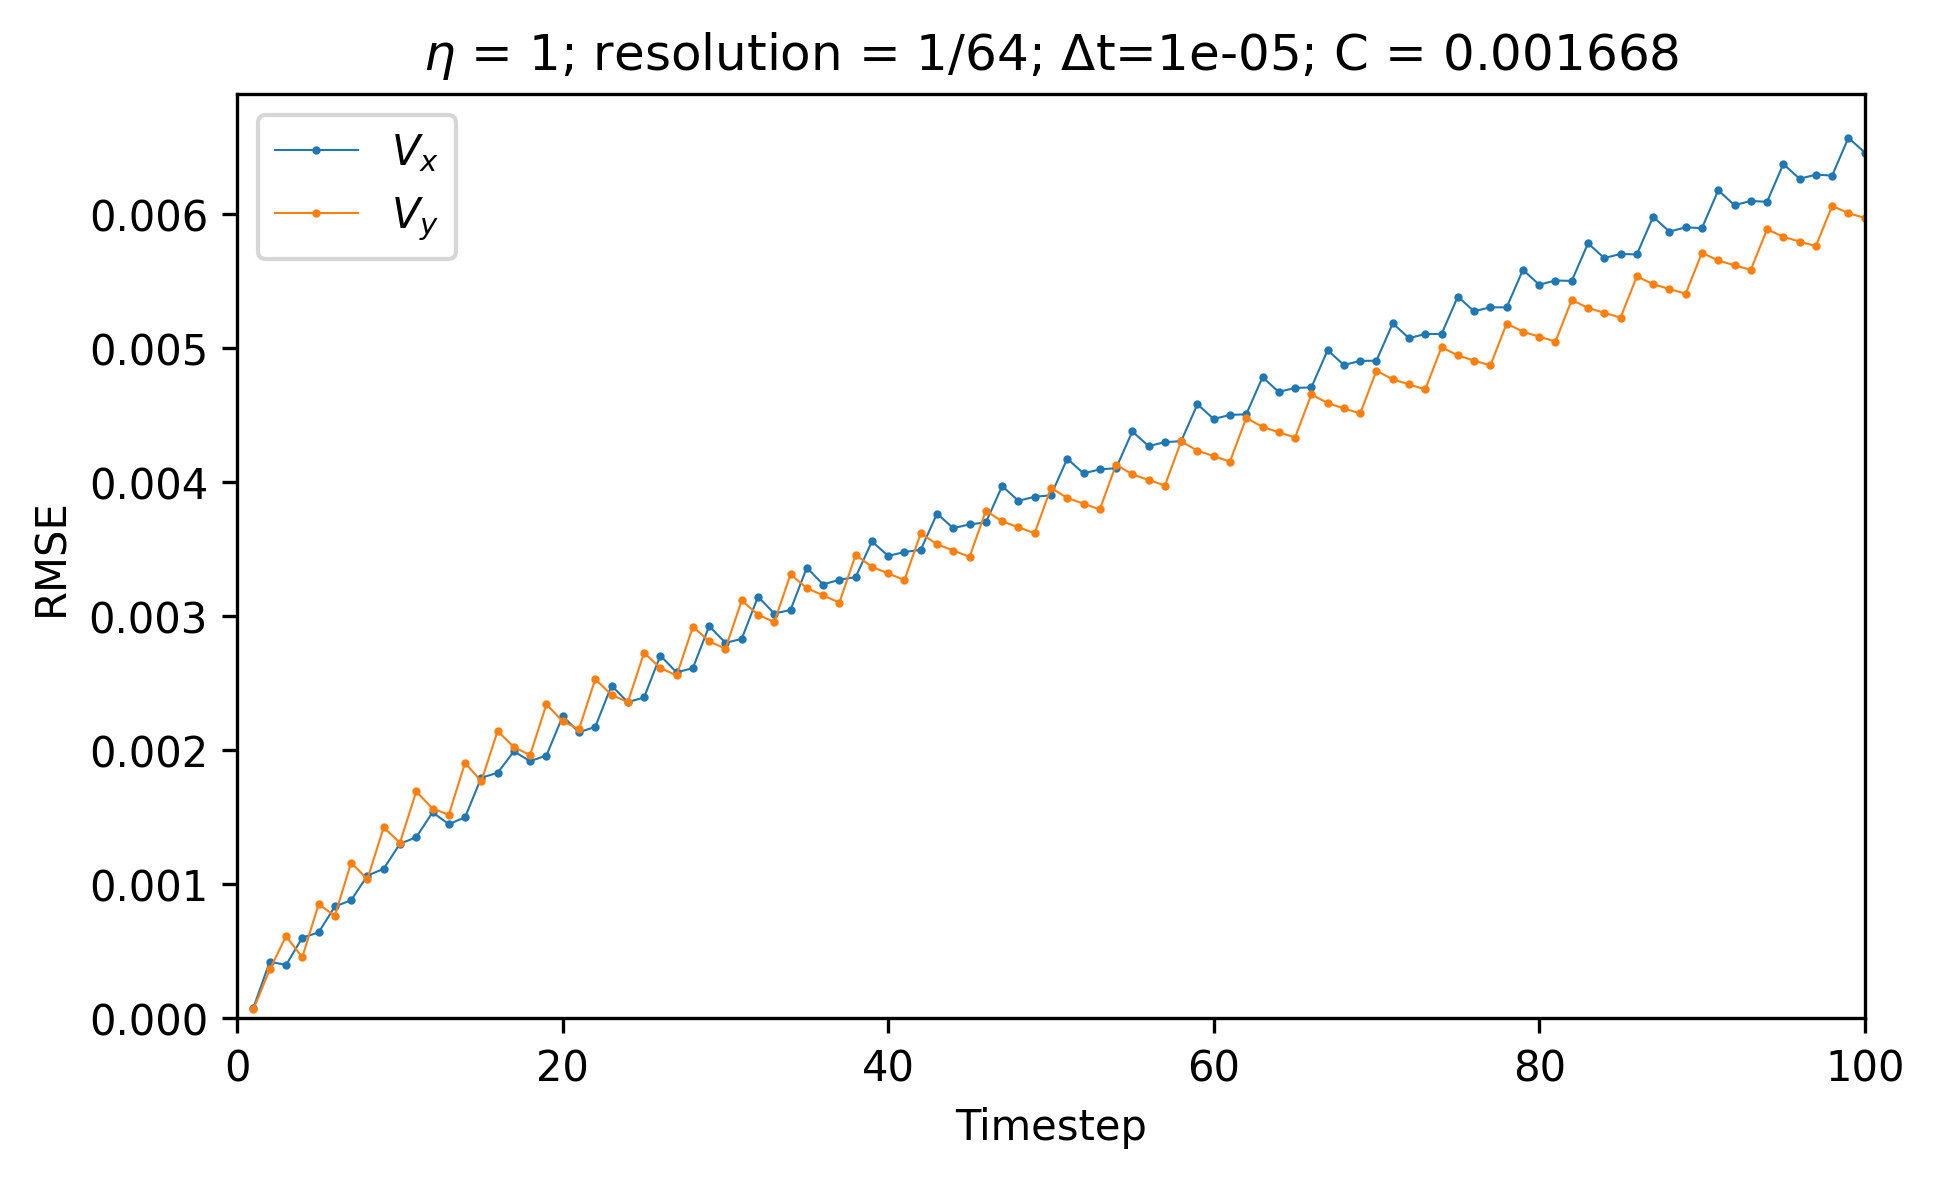

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 300, figsize = (7, 4))
ax.plot(np.arange(maxsteps) + 1, vx_rmse_arr, "-o", lw = 0.5, label = r"$V_x$", ms = 1)
ax.plot(np.arange(maxsteps) + 1, vy_rmse_arr, "-o", lw = 0.5, label = r"$V_y$", ms = 1)
ax.set_xlim([0, maxsteps])
ax.set_ylim(0)

ax.set_xlabel("Timestep")
ax.set_ylabel("RMSE")
ax.legend()

sub_title1 = r"$\eta$"
sub_title2 = r"$\Delta$t"

ax.set_title(f"{sub_title1} = {kin_visc}; resolution = 1/{resolution}; {sub_title2}={dt_ns}; C = {courant_num:.6f}")

outdir = "/Users/jgra0019/Documents/codes/uw3-dev/Navier-Stokes-benchmark/output-Burgers"
fname = f"burgers-kv{kin_visc}-res{resolution}-dt{dt_ns}-order{ns_order}.png"

fig.savefig(f"{outdir}/{fname}", dpi = "figure")

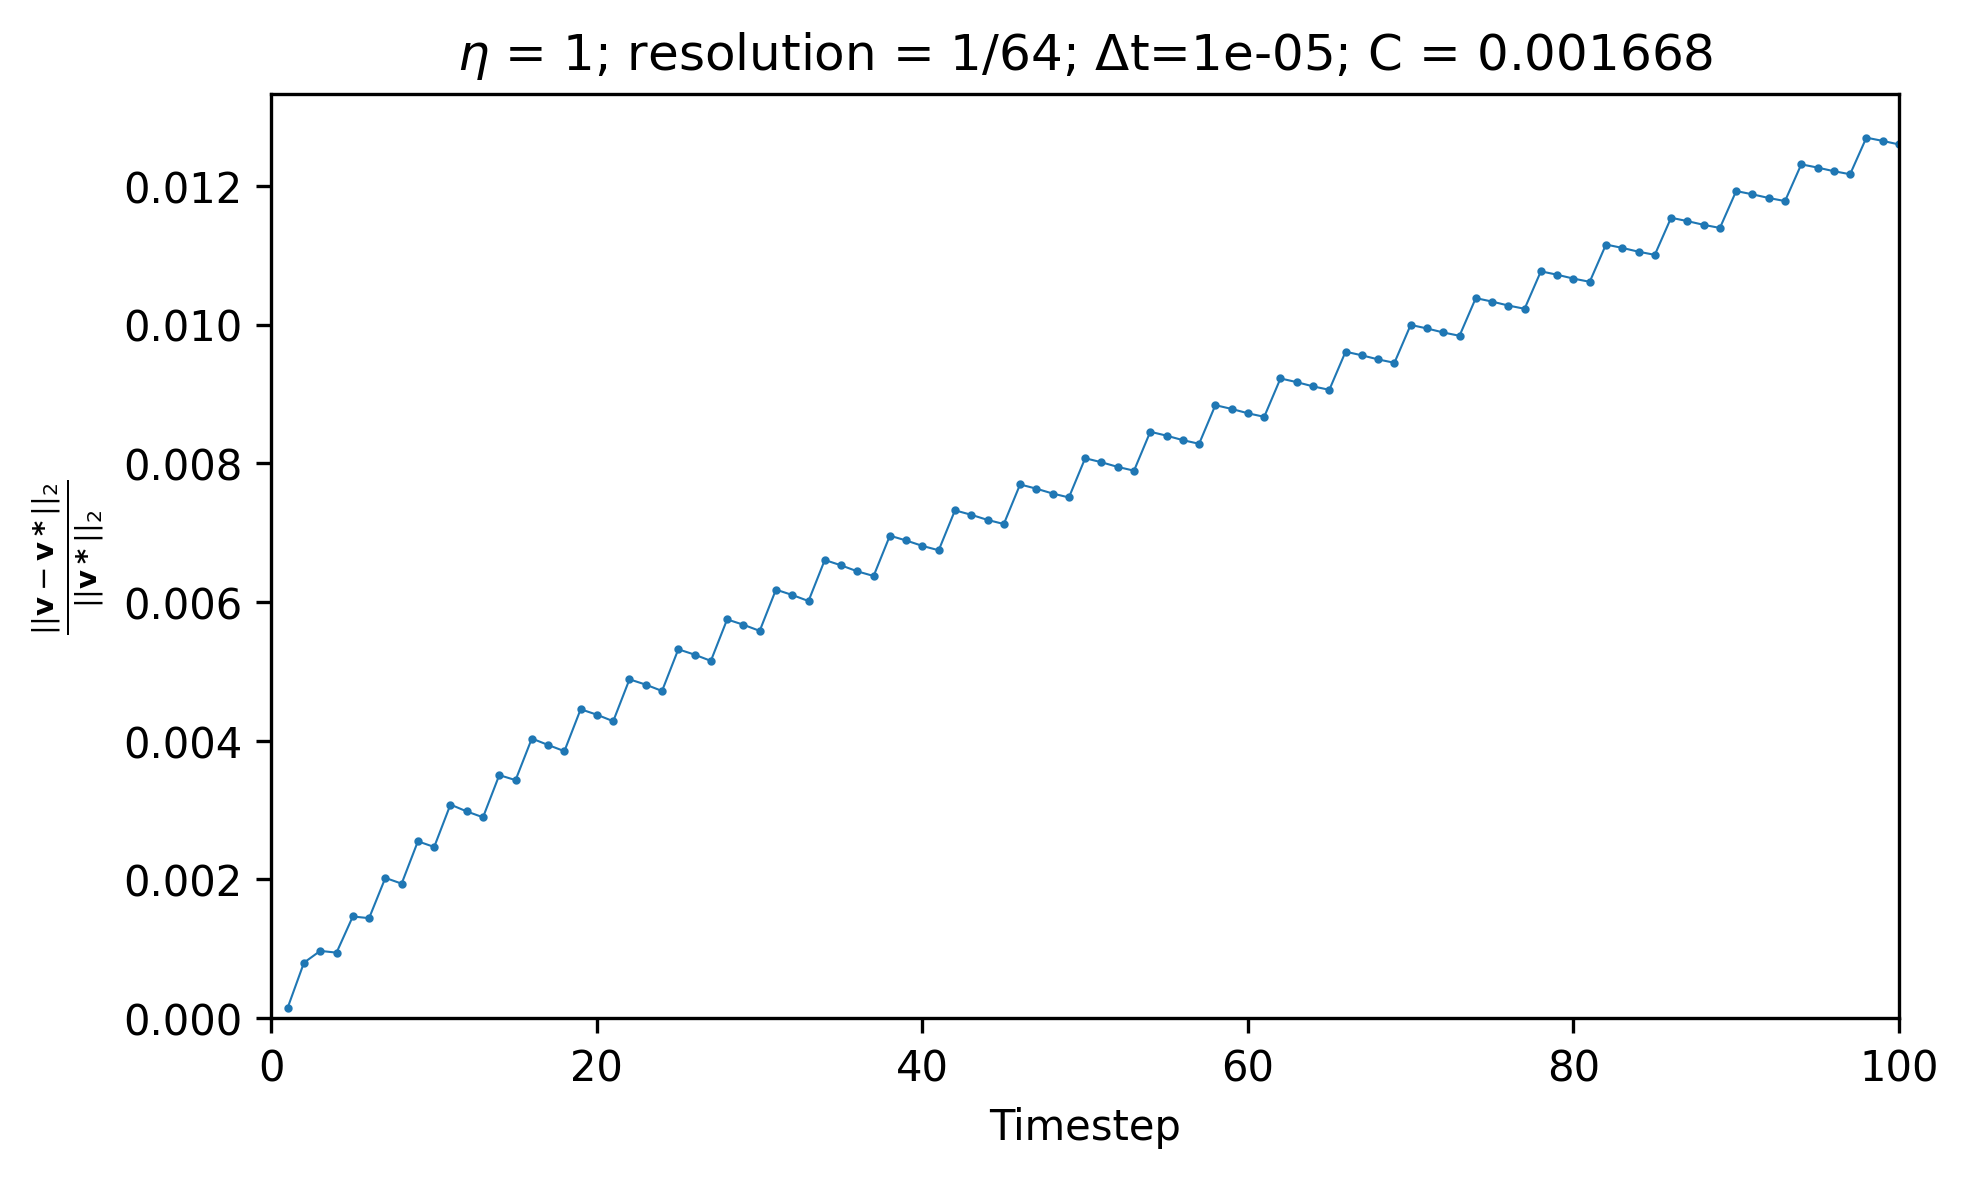

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 300, figsize = (7, 4))
ax.plot(np.arange(maxsteps) + 1, vel_norm_arr, "-o", lw = 0.5, label = r"$V_x$", ms = 1)
ax.set_xlim([0, maxsteps])
ax.set_ylim(0)

ax.set_xlabel("Timestep")
ax.set_ylabel(r"$\frac{||\mathbf{v} - \mathbf{v*}||_2}{||\mathbf{v*}||_2}$")
#ax.legend()
# ax.set_xscale("log")
# ax.set_yscale("log")

sub_title1 = r"$\eta$"
sub_title2 = r"$\Delta$t"

ax.set_title(f"{sub_title1} = {kin_visc}; resolution = 1/{resolution}; {sub_title2}={dt_ns}; C = {courant_num:.6f}")

outdir = "/Users/jgra0019/Documents/codes/uw3-dev/Navier-Stokes-benchmark/output-Burgers"
fname = f"burgers-v-relnorm-kv{kin_visc}-res{resolution}-dt{dt_ns}-order{ns_order}.png"

fig.savefig(f"{outdir}/{fname}", dpi = "figure")

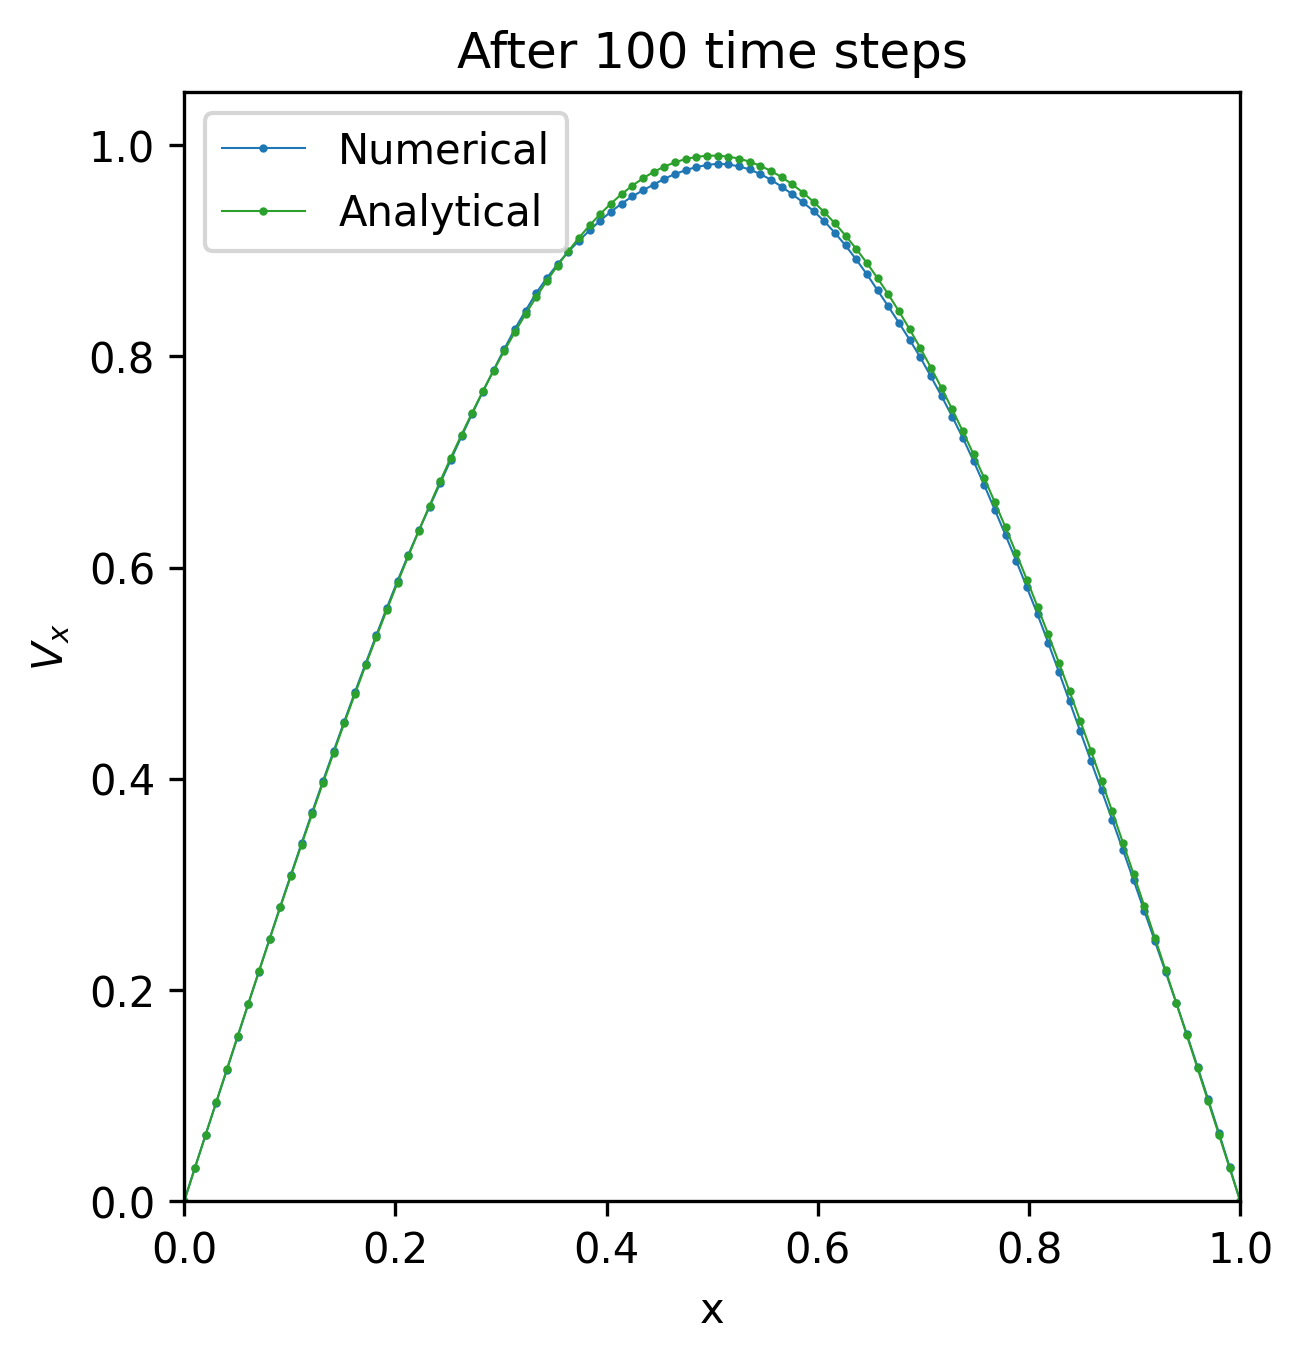

In [29]:
# import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 300)

ax.plot(xy_sample[:, 0], vx_num, "-o", lw = 0.5, label = "Numerical", ms = 1)
ax.plot(xy_sample[:, 0], v_ana2, "-o", color = "C2", lw = 0.5, label = "Analytical", ms = 1)

ax.set_xlabel("x")
ax.set_ylabel(r"$V_x$")
ax.legend()
ax.set_title(f"After {maxsteps} time steps")
ax.set_aspect("equal")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

fname = f"burgers-kv{kin_visc}-res{resolution}-dt{dt_ns}-order{ns_order}-last.png"

fig.savefig(f"{outdir}/{fname}", dpi = "figure")

RMS:  3.419441503650988e-06


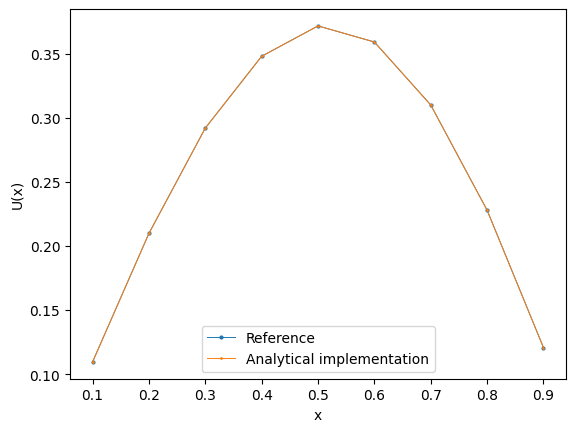

In [30]:
# reference values
x_ref = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
u_ref = np.array([0.10954, 0.20979, 0.29190, 0.34792, 0.37158, 0.35905, 0.30991, 0.22782, 0.12069])

# using sympy expression of the analytical solution
# num_test = numerator.subs(t, (maxsteps)*dt_ns)
# num_test = uw.function.evaluate(num_test, xy_sample)
# den_test = denom.subs(t, (maxsteps)*dt_ns)
# den_test = uw.function.evaluate(den_test, xy_sample)

# sampled_test = 2*np.pi*kin_visc*num_test/den_test

# compare numpy version of analytical solution with values from reference
curr_t = 0.1
v_ana3 = np.zeros_like(x_ref)
for i, x_val in enumerate(x_ref):
    v_ana3[i] = calc_ana_init_sine(x_val, curr_t, 1, a0, n_coeffs, a_coeffs)

print("RMS: ", np.sqrt(((v_ana3 - u_ref)**2).mean()))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 100)
with meshbox.access(v_soln):
    ax.plot(x_ref, u_ref, "-o", lw = 0.7, label = "Reference", ms = 2)
    ax.plot(x_ref, v_ana3, "-o", lw = 0.7, label = "Analytical implementation", ms = 1)
   
    ax.set_xlabel("x")
    ax.set_ylabel("U(x)")
    ax.legend()

0.0 0.9861018547547366


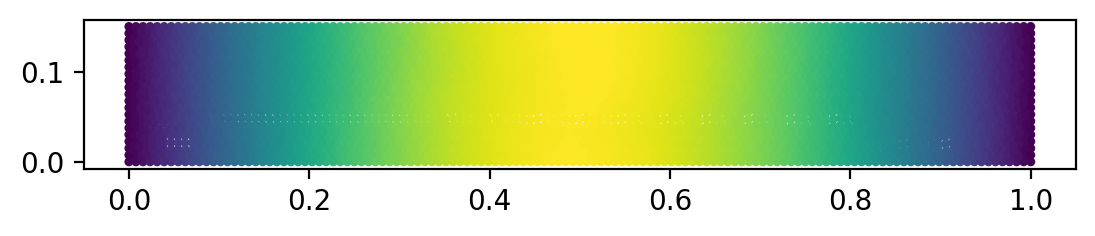

In [31]:

with meshbox.access():
    fig, ax = plt.subplots(dpi = 200)
    ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 0], s = 5)
    ax.set_aspect("equal")
    print(v_soln.data[:, 0].min(), v_soln.data[:, 0].max())

-0.02038083041614488 0.01691244091591779


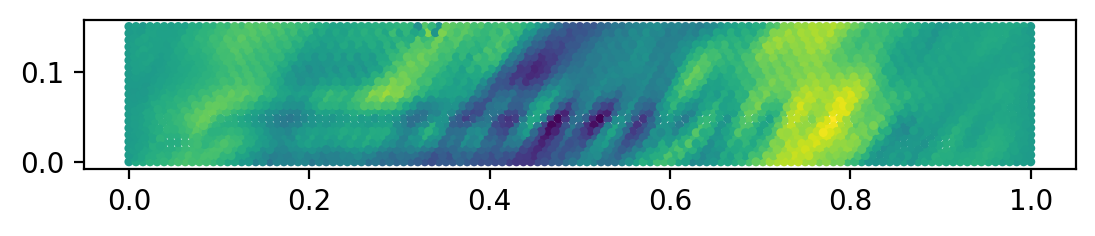

In [32]:
with meshbox.access():
    fig, ax = plt.subplots(dpi = 200)
    ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 1], s = 5)
    ax.set_aspect("equal")
    print(v_soln.data[:, 1].min(), v_soln.data[:, 1].max())